**Purpose :** of this notebook is to aggregate the DataWorkoutRun.csv, after that add meaningful features from AppleHealthKit data (aggregated data) including a binary column-whether the customer shared their AppleHealthKit data or not. Then add another column-whether the customer subscribed or not from ongouser_modeling_ds-2.csv. Next step is modeling in notebook 3 of Part B.

In [1]:
import numpy as np
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_DataWorkOutRun.csv', parse_dates=[
                 'startDate', 'joined_community_at'])
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,type,owner,session,sessionElement,track,sessionTitle,trackTitle,startDate,startLocation,runDuration,runDistance,createdAt,updatedAt,timezone,easy_id_2be_aggregated,joined_community_at
0,og.outdoor,2bb53a3f-a458-4c0d-8339-b30492b1e5f6,1d5453c4-a535-45df-9047-65d2eb00ad9f,33b57178-3213-4596-954f-96c4db9ad2a7,bc94350f-9201-4bc0-b792-f5f4abdcf6a0,Day 9: Drill Day,Marathon Program,2019-08-13 11:07:40.168,0101000020E610000018F548B4F677434017C29DDC933D...,892.070895,2351.482732,2019-08-13 11:37:42.775+00,2019-08-13 11:37:42.775+00,America/New_York,19108.0,2019-06-21 07:49:00
1,og.outdoor,4dc4c6f6-2ce5-4620-ba5c-2ed4b869998d,bbabe385-8cbd-41ac-b1e1-fea8cbef1973,21cf4c3e-e1e3-406b-a90e-4828263f038e,544e3df1-02f9-4086-8f53-7922257684c5,Day 2: Drill Day,30 Day Challenge,2019-08-13 01:02:51.095,0101000020E610000091428B2F3C44454025859E544CCC...,627.019304,1694.252356,2019-08-13 01:30:21.863+00,2019-08-13 01:30:21.863+00,America/Detroit,19074.0,2019-06-22 16:14:00


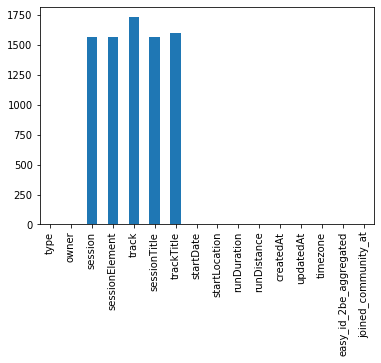

In [3]:
df.isna().sum().plot(kind='bar')

1. session, sessionelement/sessiontitle, track/tracktile contains missing values
2. We need to also look into whether missingness has any predictive power

## Generating columns to engineer weekly and monthly aggregated features 

In [4]:
# Months
df['1month_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(months=1), axis=1)
df['2month_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(months=2), axis=1)
# Weeks
df['1week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=1), axis=1)
df['2week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=2), axis=1)
df['3week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=3), axis=1)
df['4week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=4), axis=1)
df['5week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=5), axis=1)
df['6week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=6), axis=1)
df['7week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=7), axis=1)
df['8week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=8), axis=1)
# Generating weekend column
df['weekend'] = df['startDate'].dt.weekday_name
df['weekend'] = df['weekend'].apply(
    lambda x: 1 if x in['Saturday', 'Sunday'] else 0)

## Column: Type

(821, 26)

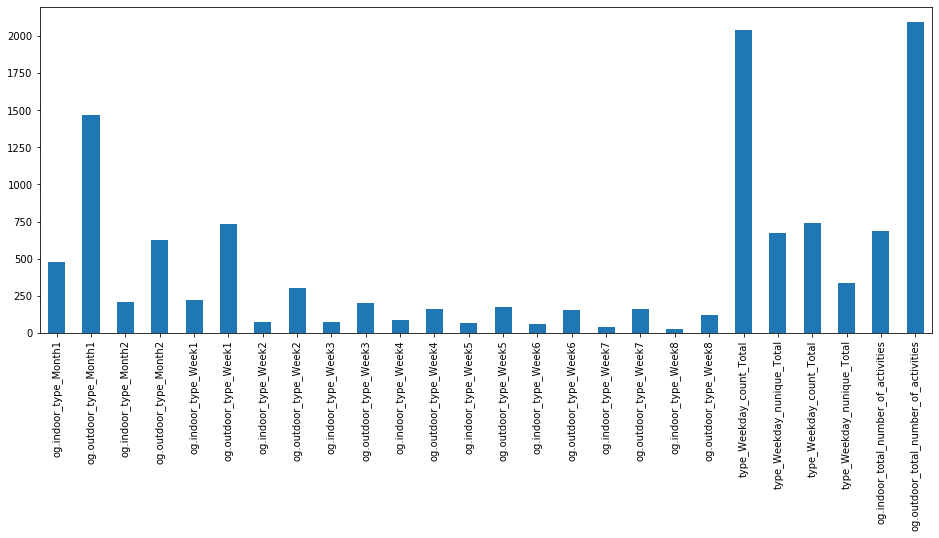

In [5]:
# Total Type
def value_counts_columnwise(df, col):
    df_prep = df.groupby('easy_id_2be_aggregated')[
        col].value_counts().unstack()
    df_prep.columns = [col+'_total_number_of_activities' for col in df_prep]
    return df_prep


def aggregate_cols(col, df):
    '''
    Purpose of this function is to aggregate various user activities for different timeframes from the time they 
    join the app to the time they subscribe (with a limit of 2 months)
    '''
    filt_1month = (df['startDate'] <= df['1month_4m_joining'])
    filt_2month = (df['startDate'] > df['1month_4m_joining']) & (
        df['startDate'] <= df['2month_4m_joining'])
    filt_1week = (df['startDate'] <= df['1week_4m_joining'])
    filt_2week = (df['startDate'] > df['1week_4m_joining']) & (
        df['startDate'] <= df['2week_4m_joining'])
    filt_3week = (df['startDate'] > df['2week_4m_joining']) & (
        df['startDate'] <= df['3week_4m_joining'])
    filt_4week = (df['startDate'] > df['3week_4m_joining']) & (
        df['startDate'] <= df['4week_4m_joining'])
    filt_5week = (df['startDate'] > df['4week_4m_joining']) & (
        df['startDate'] <= df['5week_4m_joining'])
    filt_6week = (df['startDate'] > df['5week_4m_joining']) & (
        df['startDate'] <= df['6week_4m_joining'])
    filt_7week = (df['startDate'] > df['6week_4m_joining']) & (
        df['startDate'] <= df['7week_4m_joining'])
    filt_8week = (df['startDate'] > df['7week_4m_joining']) & (
        df['startDate'] <= df['8week_4m_joining'])
    df_weekday = df[df['weekend'] == 0]
    df_weekend = df[df['weekend'] == 1]

    filts = [filt_1month, filt_2month, filt_1week, filt_2week, filt_3week, filt_4week, filt_5week, filt_6week,
             filt_7week, filt_8week, df_weekday, df_weekend]
    df_list = []
    for i in range(len(filts)):
        # Monthly aggregated data
        if i < 2:
            df_x = df[filts[i]]
            df2 = df_x.groupby('easy_id_2be_aggregated')[
                col].value_counts().unstack()
            df2.columns = [col1+'_'+str(col)+'_Month'+str(i+1)
                           for col1 in df2.columns]
            df_list.append(df2)
        # Weekly aggregated data
        if (i > 1) & (i <= 9):
            df_x = df[filts[i]]
            df2 = df_x.groupby('easy_id_2be_aggregated')[
                col].value_counts().unstack()
            df2.columns = [col1+'_'+str(col)+'_Week'+str(i-1)
                           for col1 in df2.columns]
            df_list.append(df2)
        # Weekday-weekend aggregated data
        if i == 10:
            df_x = filts[i].groupby('easy_id_2be_aggregated').agg(
                {'weekend': ['count', 'nunique']})
            df_x.reset_index()
            df_x.columns = [str(col)+'_Weekday_'+str(col1[1]) +
                            '_Total' for col1 in df_x.columns]
            df_list.append(df_x)
        if i == 11:
            df_x = filts[i].groupby('easy_id_2be_aggregated').agg(
                {'weekend': ['count', 'nunique']})
            df_x.reset_index()
            df_x.columns = [str(col)+'_Weekday_'+str(col1[1]) +
                            '_Total' for col1 in df_x.columns]
            df_list.append(df_x)
    return df_list


outdoor_indoor_value_counts_Total = value_counts_columnwise(df=df, col='type')
# type: over months,weeks, and weekends
df_type = aggregate_cols(col='type', df=df)
data1 = [x for x in df_type]
data1 = pd.concat(data1, axis=1)
data1 = pd.concat([data1, outdoor_indoor_value_counts_Total], axis=1)
data1.sum().plot(kind='bar', figsize=(16, 6))
data1.shape

## Column: Session

In [6]:
# Would be great to see if missing values have any hidden predictive power
df['session2'] = df['session'].fillna('session_Missing')

df_session_missing = df[df['session2'] == 'session_Missing']
df_session_missing = df_session_missing.groupby(
    'easy_id_2be_aggregated').agg({'session2': ['count']})
df_session_missing.columns = ['session_missing_total']
df_session_Total = df.groupby('easy_id_2be_aggregated').agg(
    {'session': ['count', 'nunique']})
df_session_Total.columns = ['session_total', 'session_unique_total']

(821, 13)

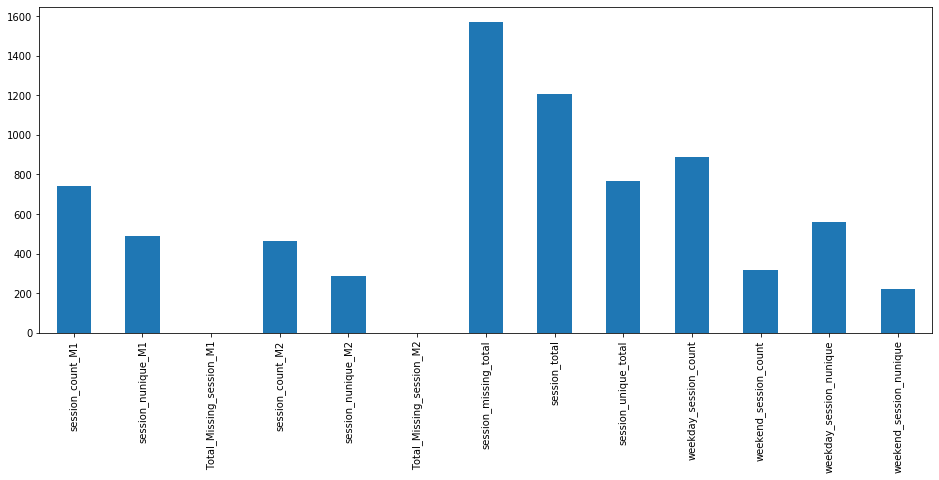

In [7]:
def aggregate_cols_count_nunique(df, col, col2):
    '''
    Purpose of this function is to aggregate various user activities for different timeframes from the time they 
    join the app to the time they subscribe (with a limit of 2 months)
    '''
    filt_1month = (df['startDate'] <= df['1month_4m_joining'])
    filt_2month = (df['startDate'] > df['1month_4m_joining']) & (
        df['startDate'] <= df['2month_4m_joining'])

    filts = [filt_1month, filt_2month]
    col_name = ['_M1', '_M2']
    df_list = []
    for i in range(len(filts)):
        # Monthly aggregated data
        if i < 2:
            df_x = df[filts[i]]
            df2 = df_x.groupby('easy_id_2be_aggregated').agg(
                {col: ['count', 'nunique']})
            df2.columns = [str(col)+'_'+str(column[1])+col_name[i]
                           for column in df2]
            df_list.append(df2)
            df_x_missing = df_x[df_x[col2] == 'Missing']
            df_x_missing = df_x_missing.groupby(
                'easy_id_2be_aggregated').agg({col2: ['count']})
            df_x_missing.columns = ['Total_Missing_'+str(col)+col_name[i]]
            df_list.append(df_x_missing)
    return df_list


# weekday vs weekend
df_session_weekday_weekend = df.groupby(['easy_id_2be_aggregated', 'weekend']).agg({
    'session': ['count', 'nunique']}).unstack()
df_session_weekday_weekend.columns = [
    'weekday_session_count', 'weekend_session_count', 'weekday_session_nunique', 'weekend_session_nunique']

df_session = aggregate_cols_count_nunique(
    df=df, col='session', col2='session2')
data2 = [x for x in df_session]
data2 = pd.concat(data2, axis=1)
data2 = pd.concat([data2, df_session_missing, df_session_Total,
                   df_session_weekday_weekend], axis=1)
data2.sum().plot(kind='bar', figsize=(16, 6))
data2.shape

## SessionTitle and SessionElement similar

In [8]:
# Would be great to see if missing values have any hidden predictive power
df['sessionTitle2'] = df['sessionTitle'].fillna('Missing_sessionTitle2')

df_sessionTitle_missing = df[df['sessionTitle2'] == 'Missing_sessionTitle2']
df_sessionTitle_missing = df_sessionTitle_missing.groupby(
    'easy_id_2be_aggregated').agg({'sessionTitle2': ['count']})
df_sessionTitle_missing.columns = ['sessionTitle2_missing_total']
df_sessionTitle_Total = df.groupby('easy_id_2be_aggregated').agg(
    {'sessionTitle': ['count', 'nunique']})
df_sessionTitle_Total.columns = [
    'sessionTitle_total_count', 'sessionTitle_total_nunique']

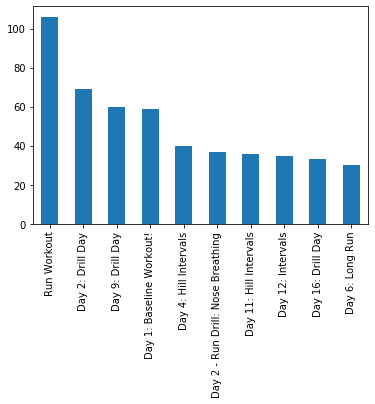

In [9]:
# Infrequent sessionTitle replaced by others
sessionTitle2 = df['sessionTitle2'].value_counts(normalize=True)
index = sessionTitle2[sessionTitle2 < 0.01].index
df['sessionTitle2'] = df['sessionTitle2'].replace(
    {x: 'Other_sessionTitle2' for x in index})
# Most liked sessionTitle
df['sessionTitle2'].value_counts()[df['sessionTitle2'].value_counts(
    normalize=True) < 0.25].plot(kind='bar')

index = sessionTitle2[sessionTitle2 < 0.02].index
df['sessionTitle2'] = df['sessionTitle2'].replace(
    {x: 'Other_sessionTitle2' for x in index})
df_sessionTitle2 = df.groupby(
    'easy_id_2be_aggregated').sessionTitle2.value_counts().unstack().fillna(0)
df_sessionTitle2.columns = ['Day 1: Baseline Workout', 'Day 2: Drill Day', 'Day 9: Drill Day',
                            'Missing_sessionTitle2', 'Other_sessionTitle2', 'Run Workout']

This plot shows most **popular session titles**

(821, 19)

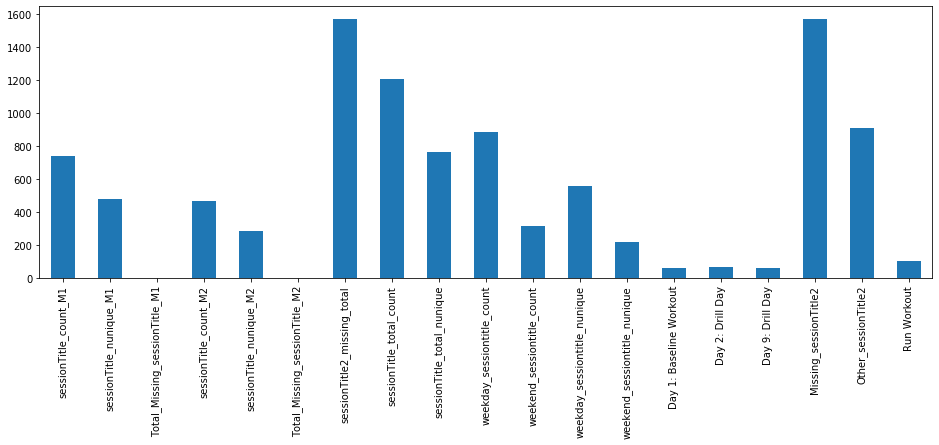

In [10]:
# weekday vs weekend
df_sessionTitle_weekday_weekend = df.groupby(['easy_id_2be_aggregated', 'weekend']).agg({
    'sessionTitle': ['count', 'nunique']}).unstack()
df_sessionTitle_weekday_weekend.columns = ['weekday_sessiontitle_count', 'weekend_sessiontitle_count',
                                           'weekday_sessiontitle_nunique', 'weekend_sessiontitle_nunique']

df_sessionTitle = aggregate_cols_count_nunique(
    df=df, col='sessionTitle', col2='sessionTitle2')
data3 = [x for x in df_sessionTitle]
data3 = pd.concat(data3, axis=1)
data3 = pd.concat([data3, df_sessionTitle_missing, df_sessionTitle_Total, df_sessionTitle_weekday_weekend,
                   df_sessionTitle2], axis=1)
data3.sum().plot(kind='bar', figsize=(16, 5))
data3.shape

## Column: TrackTitle

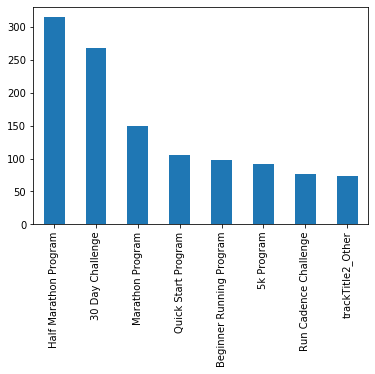

In [11]:
# This would be great to see if missing values have any hidden predictive power
df['trackTitle2'] = df['trackTitle'].fillna('trackTitle2_Missing')

df_trackTitle_missing = df[df['trackTitle2'] == 'trackTitle2_Missing']
df_trackTitle_missing = df_trackTitle_missing.groupby(
    'easy_id_2be_aggregated').agg({'trackTitle2': ['count']})
df_trackTitle_missing.columns = ['trackTitle2_missing_total']
df_trackTitle_Total = df.groupby('easy_id_2be_aggregated').agg(
    {'trackTitle': ['count', 'nunique']})
df_trackTitle_Total.columns = ['trackTitle_total', 'trackTitle_nunique']

# Infrequent trackTitle replaced by others
trackTitle2 = df['trackTitle2'].value_counts(normalize=True)
index = trackTitle2[trackTitle2 < 0.02].index
df['trackTitle2'] = df['trackTitle2'].replace(
    {x: 'trackTitle2_Other' for x in index})
# Most liked Half Marathon program
df['trackTitle2'].value_counts()[df['trackTitle2'].value_counts(
    normalize=True) < 0.5].plot(kind='bar')

df_trackTitle2 = df.groupby(
    'easy_id_2be_aggregated').trackTitle2.value_counts().unstack().fillna(0)
df_trackTitle2 = df.groupby(
    'easy_id_2be_aggregated').trackTitle2.value_counts().unstack().fillna(0)
df_trackTitle2.columns = ['30 Day Challenge', '5k Program', 'Beginner Running Program',
                          'Half Marathon Program', 'Marathon Program', 'trackTitle2_Missing', 'rackTitle2_Other',
                          'Quick Start Program', 'Run Cadence Challenge']

(821, 22)

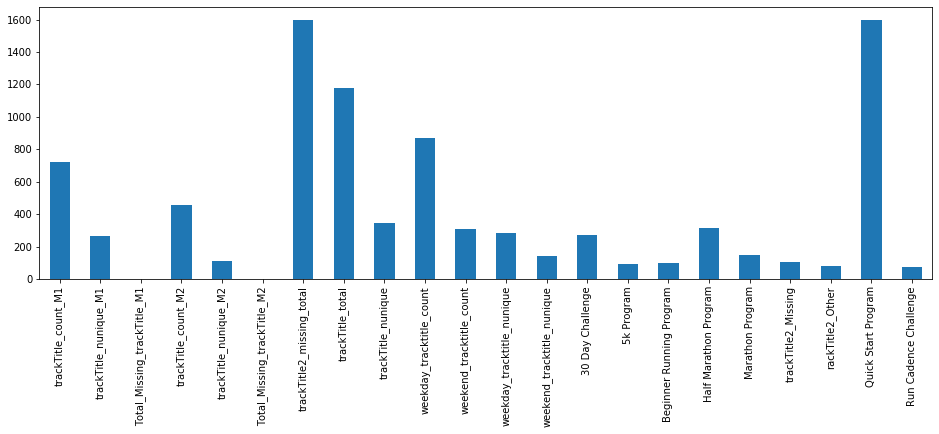

In [12]:
# weekday vs weekend
df_trackTitle_weekday_weekend = df.groupby(['easy_id_2be_aggregated', 'weekend']).agg({
    'trackTitle': ['count', 'nunique']}).unstack()
df_trackTitle_weekday_weekend.columns = ['weekday_tracktitle_count', 'weekend_tracktitle_count',
                                         'weekday_tracktitle_nunique', 'weekend_tracktitle_nunique']

df_trackTitle = aggregate_cols_count_nunique(
    df=df, col='trackTitle', col2='trackTitle2')
data4 = [x for x in df_trackTitle]
data4 = pd.concat(data4, axis=1)
data4 = pd.concat([data4, df_trackTitle_missing, df_trackTitle_Total, df_trackTitle_weekday_weekend,
                   df_trackTitle2], axis=1)
data4.sum().plot(kind='bar', figsize=(16, 5))
data4.shape

## Column: TimeZone

In [13]:
# Only 2 values missing, replaced with mode
df['timezone'].fillna('America/New_York', inplace=True)
# Splitting timezone into continents and cities
df['continent'] = df['timezone'].str.split('/').apply(lambda x: x[0])
df['city'] = df['timezone'].str.split('/').apply(lambda x: x[1])

# Unique continent and cities an user has been
df_continent = df.groupby('easy_id_2be_aggregated').agg(
    {'continent': ['nunique']})
df_continent.columns = ['unique_continents']
df_city = df.groupby('easy_id_2be_aggregated').agg({'city': ['nunique']})
df_city.columns = ['unique_city']

# Removing extremely rare cities
city = df['city'].value_counts(normalize=True)
index = city[city < 0.01].index
df['city'] = df['city'].replace({x: 'Other_city' for x in index})

In [14]:
def column_runDuration_Distance(df, col1, col2, aggfunc):
    '''
    Calculating runDistance and runDuration based on various columns
    '''
    df_eng = df.pivot_table(index='easy_id_2be_aggregated',
                            columns=col1, values=col2, aggfunc=aggfunc)
    df_eng.columns = [i+'_'+str(col2)+'_'+str(aggfunc) for i in df_eng.columns]
    return df_eng


columns = ['continent', 'city', 'trackTitle2', 'sessionTitle2', 'type']
df_list = []
for i in range(len(columns)):
    a = column_runDuration_Distance(
        df=df, col1=columns[i], col2='runDuration', aggfunc='mean')
    df_list.append(a)
    b = column_runDuration_Distance(
        df=df, col1=columns[i], col2='runDistance', aggfunc='mean')
    df_list.append(b)

data5 = [x for x in df_list]
data5 = pd.concat(data5, axis=1)
data5 = pd.concat([data5, df_continent, df_city], axis=1)
#data5.sum().plot(kind='bar', figsize=(16,5))
data5.shape

(821, 74)

## Column: Duration

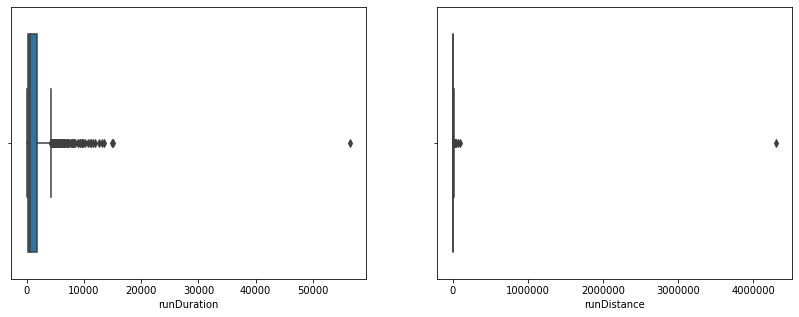

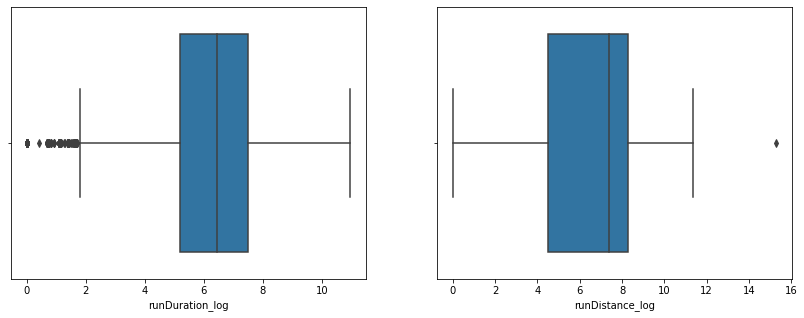

In [15]:
import scipy.stats as st
from scipy.stats import norm, skew
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
columns = ['runDuration', 'runDistance']
for i in range(len(columns)):
    sns.boxplot(df[columns[i]], ax=axes[i])
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# These are not normally distributed, log transformation would be helpful
for i in range(len(columns)):
    df[columns[i]+str('_log')] = np.log1p(df[columns[i]])
    sns.boxplot(df[columns[i]+str('_log')], ax=axes[i])

Some people are more active than most, it could have a predictive value, so I would extract that information below

In [16]:
runDuration_index = df[df['runDuration'] > 5000].index.values
runDuration_index = [i for i in runDuration_index]
runDistance_index = df[df['runDistance'] > 10000].index.values
runDistance_index = [i for i in runDistance_index]
more_active = runDuration_index+runDistance_index
print(
    f'Total {len(set(more_active))} number people run longer distance and duration')
df['more_active'] = df['runDistance'].index.isin(more_active)
df['more_active'] = df['more_active'].map({False: 0, True: 1})

Total 162 number people run longer distance and duration


In [17]:
from collections import Counter


def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)
                              | (df[col] > Q3 + outlier_step)].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers


# detect outliers after transformation
Outliers_to_drop = detect_outliers(
    df, 1, ['runDuration_log', 'runDistance_log'])
print(f'No. of outliers after log transformation: {len(Outliers_to_drop)}')

No. of outliers after log transformation: 0


A lot of runduration are 0, which are mistake on users (might be the user got into the app mistakenly, started and relaizing its a mistake, closed the app) part and I will treat them separately.

In [18]:
more_active = df.groupby('easy_id_2be_aggregated').agg(
    {'more_active': ['mean', 'sum']})
more_active.columns = ['more_active_mean', 'more_active_sum']

# Fake runDuration
df_fake_runDuration = df[df['runDuration_log'] == 0]
df_fake_runDuration_total_count = df_fake_runDuration.groupby(
    'easy_id_2be_aggregated').agg({'runDuration_log': 'count'})
df_fake_runDuration_total_count.columns = ['Total_0_runDuration']
print(
    f'There are people who has opened the app and covered 0 distance : {df_fake_runDuration_total_count.max().values[0]} times')

There are people who has opened the app and covered 0 distance : 9 times


(821, 38)

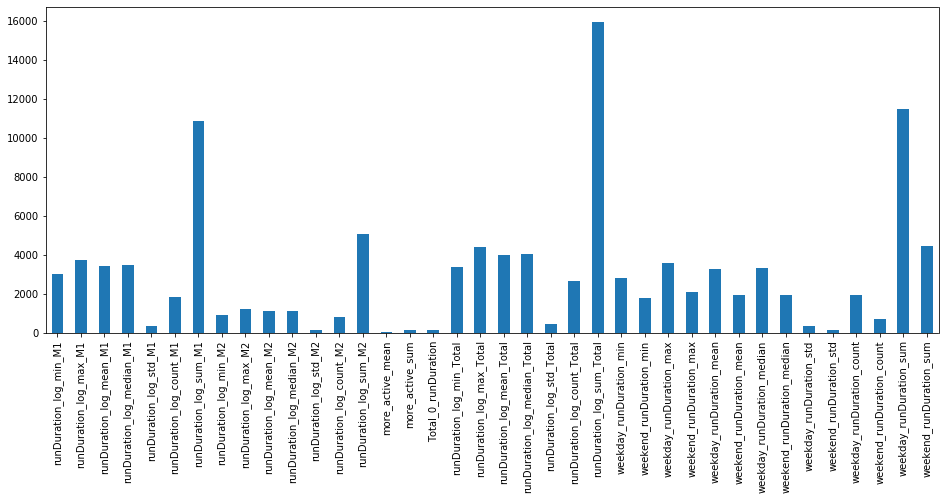

In [19]:
def real_runDur_runDist_total(df, col, func):
    '''
    Statistics on run distance/duration per individual
    '''
    df_real_runDuration = df[df[col] > 0]
    df_runDuration_total = df_real_runDuration.groupby(
        'easy_id_2be_aggregated').agg({col: func})
    df_runDuration_total.columns = [
        str(col[0])+'_'+str(col[1])+'_Total' for col in df_runDuration_total.columns]
    return df_runDuration_total


def real_runDur_runDist_month(df, col, func):
    '''
    Purpose of this function is to aggregate runDuration and runDistance for different timeframes from the time customers
    join the app to the time they subscribe (with a limit of 2 months)
    '''
    filt_1month = (df['startDate'] <= df['1month_4m_joining'])
    filt_2month = (df['startDate'] > df['1month_4m_joining']) & (
        df['startDate'] <= df['2month_4m_joining'])
    filts = [filt_1month, filt_2month]
    col_name = ['_M1', '_M2']
    df_list = []
    for i in range(len(filts)):
        # Monthly aggregated data
        df_x = df[filts[i]]
        df2 = df_x.groupby('easy_id_2be_aggregated').agg({col: func})
        df2.columns = [str(col)+'_'+str(column[1])+col_name[i]
                       for column in df2]
        df_list.append(df2)
    return df_list


runDurDist_total = real_runDur_runDist_total(df=df, col='runDuration_log', func=[
                                             'min', 'max', 'mean', 'median', 'std', 'count', 'sum'])
# Real runDuration
df_real_runDuration = df[df['runDuration_log'] > 0]
runDur = real_runDur_runDist_month(df=df_real_runDuration, col='runDuration_log', func=[
                                   'min', 'max', 'mean', 'median', 'std', 'count', 'sum'])
# weekday vs weekend
df_real_runDuration_weekday_weekend = df_real_runDuration.groupby(['easy_id_2be_aggregated', 'weekend'
                                                                   ]).agg({'runDuration_log': ['min', 'max', 'mean', 'median', 'std', 'count', 'sum']}).unstack()
df_real_runDuration_weekday_weekend.columns = ['weekday_runDuration_min', 'weekend_runDuration_min',
                                               'weekday_runDuration_max', 'weekend_runDuration_max',
                                               'weekday_runDuration_mean', 'weekend_runDuration_mean',
                                               'weekday_runDuration_median', 'weekend_runDuration_median',
                                               'weekday_runDuration_std', 'weekend_runDuration_std',
                                               'weekday_runDuration_count', 'weekend_runDuration_count',
                                               'weekday_runDuration_sum', 'weekend_runDuration_sum']

data6 = [x for x in runDur]
data6 = pd.concat(data6, axis=1)
data6 = pd.concat([data6, more_active, df_fake_runDuration_total_count, runDurDist_total,
                   df_real_runDuration_weekday_weekend], axis=1)
data6.sum().plot(kind='bar', figsize=(16, 6))
data6.shape

## Column: Distance

A lot of runDistance are 0, which are mistake of users (might be the user got into the app mistakenly, started and relaizing its a mistake, closed the app) part and I will treat them separately as well. 

In [20]:
# Fake runDistance
df_fake_runDistance = df[df['runDistance_log'] == 0]
df_fake_runDistance_total_count = df_fake_runDistance.groupby(
    'easy_id_2be_aggregated').agg({'runDistance_log': 'count'})
df_fake_runDistance_total_count.columns = ['Total_0_runDistance']
print(
    f'There are people who has opened the app and covered 0 distance : {df_fake_runDistance_total_count.max().values[0]} times')
# runDistance aggregate
runDist_total = real_runDur_runDist_total(df=df, col='runDistance_log', func=[
                                          'min', 'max', 'mean', 'median', 'std', 'count', 'sum'])

There are people who has opened the app and covered 0 distance : 15 times


(821, 36)

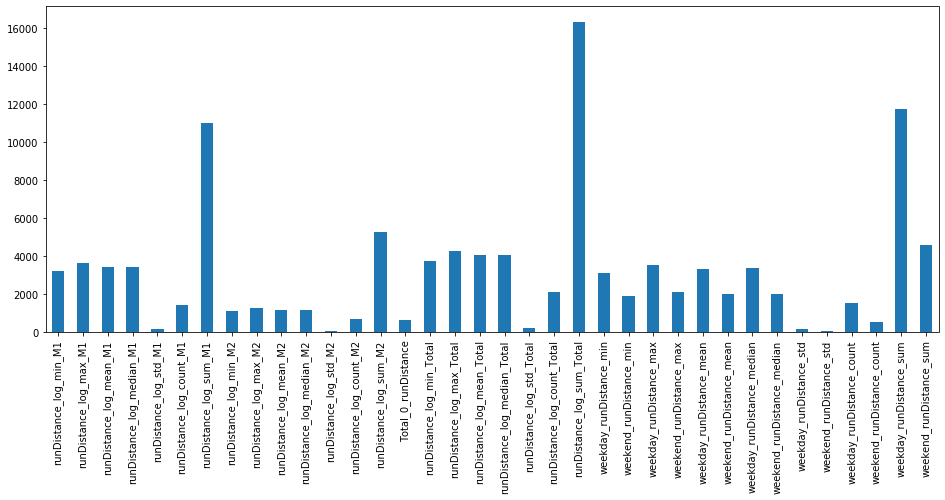

In [21]:
# Real runDistance
df_real_runDistance = df[df['runDistance_log'] > 0]
runDist = real_runDur_runDist_month(df=df_real_runDistance, col='runDistance_log',
                                    func=['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])
# weekday vs weekend
df_real_runDistance_weekday_weekend = df_real_runDistance.groupby(['easy_id_2be_aggregated',
                                                                   'weekend']).agg({'runDistance_log': ['min', 'max', 'mean', 'median', 'std', 'count', 'sum']}).unstack()
df_real_runDistance_weekday_weekend.columns = ['weekday_runDistance_min', 'weekend_runDistance_min',
                                               'weekday_runDistance_max', 'weekend_runDistance_max',
                                               'weekday_runDistance_mean', 'weekend_runDistance_mean',
                                               'weekday_runDistance_median', 'weekend_runDistance_median',
                                               'weekday_runDistance_std', 'weekend_runDistance_std',
                                               'weekday_runDistance_count', 'weekend_runDistance_count',
                                               'weekday_runDistance_sum', 'weekend_runDistance_sum']

data7 = [x for x in runDist]
data7 = pd.concat(data7, axis=1)
data7 = pd.concat([data7, df_fake_runDistance_total_count, runDist_total,
                   df_real_runDistance_weekday_weekend], axis=1)
data7.sum().plot(kind='bar', figsize=(16, 6))
data7.shape

## Engineered Feature: Speed (meter/sec)

In [22]:
df_speed = df[(df['runDistance'] > 0) & (df['runDuration'] > 0)]
df['speed'] = df_speed['runDistance']/df_speed['runDuration']
print('{} people have speed over Usian Bolt'.format(
    df[df['speed'] > 12].shape[0]))
df['speed'].max()

37 people have speed over Usian Bolt


61820.0

 Human beings can run as fast as 12.07 meters per second, some speeds are way over that. Either units got changed or some other issues such as travelling in car, need to be removed

In [23]:
speed_outlier_index = df[df['speed'] > 12].index.values
df['Abnormal_Speed'] = df['speed'].index.isin(speed_outlier_index)
df['Abnormal_Speed'] = df['Abnormal_Speed'].map({False: 0, True: 1})
filt = df['speed'].index.isin(speed_outlier_index)
df.loc[filt, 'speed'] = 0
# Speed outliers removed
df[df['speed'] > 12]

,type,owner,session,sessionElement,track,sessionTitle,trackTitle,startDate,startLocation,runDuration,...,session2,sessionTitle2,trackTitle2,continent,city,runDuration_log,runDistance_log,more_active,speed,Abnormal_Speed


(821, 35)

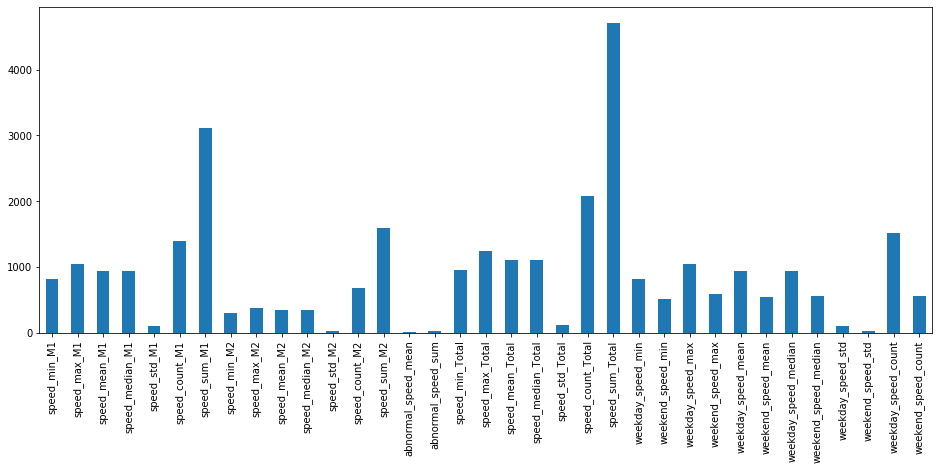

In [24]:
abnormal_speed = df.groupby('easy_id_2be_aggregated').agg(
    {'Abnormal_Speed': ['mean', 'sum']})
abnormal_speed.columns = ['abnormal_speed_mean', 'abnormal_speed_sum']

# Speed
df_real_speed = df[df['speed'] > 0]
# Speed aggregate
runSpeed_total = real_runDur_runDist_total(df=df, col='speed', func=[
                                           'min', 'max', 'mean', 'median', 'std', 'count', 'sum'])
# weekday vs weekend
df_real_speed_weekday_weekend = df_real_speed.groupby(['easy_id_2be_aggregated',
                                                       'weekend']).agg({'speed': ['min', 'max', 'mean', 'median', 'std', 'count']}).unstack()
df_real_speed_weekday_weekend.columns = ['weekday_speed_min', 'weekend_speed_min',
                                         'weekday_speed_max', 'weekend_speed_max',
                                         'weekday_speed_mean', 'weekend_speed_mean',
                                         'weekday_speed_median', 'weekend_speed_median',
                                         'weekday_speed_std', 'weekend_speed_std',
                                         'weekday_speed_count', 'weekend_speed_count']
runSpeed = real_runDur_runDist_month(df=df_real_speed, col='speed', func=[
                                     'min', 'max', 'mean', 'median', 'std', 'count', 'sum'])
data8 = [x for x in runSpeed]
data8 = pd.concat(data8, axis=1)
data8 = pd.concat([data8, abnormal_speed, runSpeed_total,
                   df_real_speed_weekday_weekend], axis=1)
data8.sum().plot(kind='bar', figsize=(16, 6))
data8.shape

In [25]:
# Combining all aggregated and engineered columns
df_DataWorkoutRun_aggregated = pd.concat(
    [data1, data2, data3, data4, data5, data6, data7, data8], axis=1)
#df_DataWorkoutRun_aggregated = df_DataWorkoutRun_aggregated.fillna(0)
print(
    f'Total shape of aggregated columns: {df_DataWorkoutRun_aggregated.shape}')

Total shape of aggregated columns: (821, 263)


## Incorporating data from synced AppleHealthKit Data 

1. Rules: shared data: 1, not shared:0 #cluster: 0, cluster:1, rest:Missing - categorical
2. Top features that helped to separate individuals into different clusters

In [26]:
df = pd.read_csv('clean_DataWorkOutRun.csv', parse_dates=[
                 'startDate', 'joined_community_at'])
df.drop(columns=['Unnamed: 0'], inplace=True)

dicti = {}
for i in df['owner'].unique():
    filt = df['owner'] == i
    dicti[i] = df.loc[filt, 'easy_id_2be_aggregated'].unique()[0]

dicti2 = {}
for i in df['easy_id_2be_aggregated'].unique():
    filt = df['easy_id_2be_aggregated'] == i
    dicti2[i] = df.loc[filt, 'owner'].unique()[0]

In [27]:
# AppleHealthData
df_x = pd.read_csv("df_clean.csv", parse_dates=["startdate", "enddate"])
df_x.head(2)

,_id,owner,easy_id,source,type,startdate,enddate,value,continent,city
0,013dbe8e-4388-571a-a475-46cdccb95124,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-heart-rate,2019-05-03 14:53:31.783,2019-05-03 14:53:31.783,100.000000,America,New_York
1,01cfa004-e070-59a9-9044-a33df3d0e5ed,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-step-distance,2019-06-28 16:59:51.148,2019-06-28 16:59:53.706,2.549228,America,New_York


In [28]:
df_x['easy_id2'] = df_x['owner'].map(dicti)
df_z = df_x.loc[:, ['owner', 'easy_id2']]
df_z2 = df_z[df_z['easy_id2'].notna()]
# People who synced AppleHealthKitData
synced_data = df_z2['easy_id2'].to_list()
# Integrating that into the engineered aggregated data
df_DataWorkoutRun_aggregated['shared_apple_data'] = df_DataWorkoutRun_aggregated.index.isin(
    synced_data)
df_DataWorkoutRun_aggregated['shared_apple_data'] = df_DataWorkoutRun_aggregated['shared_apple_data'].map({
                                                                                                          True: 1, False: 0})

In [29]:
# Adding more data from aggregated ApplehealthKit # clusters # columns that segregate the clusters well
df_apple_agg = pd.read_csv('df_2_add_2_DataWorkoutRun.csv')
df_apple_agg['easy_id2'] = df_apple_agg['owner'].map(dicti)
df_apple_agg_selected = df_apple_agg[df_apple_agg['easy_id2'].notna()]
df_apple_agg_selected.index = df_apple_agg_selected['easy_id2']
df_apple_agg_selected = df_apple_agg_selected.drop(
    columns=['easy_id', 'owner', 'easy_id2'])

# Total data from all aggregated columns from DataWorkOutRun and AppleHealthKitData (for sync in users)
df_DataWorkoutRun_aggregated = pd.concat(
    [df_DataWorkoutRun_aggregated, df_apple_agg_selected], axis=1)

# Removing missing values
df_DataWorkoutRun_aggregated['kmeans_pred'] = df_DataWorkoutRun_aggregated['kmeans_pred'].fillna(
    'Missing')

# df_DataWorkoutRun_aggregated.fillna(0,inplace=True) #df_DataWorkoutRun_aggregated.isna().sum().sum()
df_DataWorkoutRun_aggregated.shape

(821, 275)

In [30]:
df_DataWorkoutRun_aggregated['owner'] = df_DataWorkoutRun_aggregated.index.map(
    dicti2)
df_DataWorkoutRun_aggregated.to_csv(
    "df_DataWorkoutRun_aggregated.csv", index=True)
df = pd.read_csv('df_DataWorkoutRun_aggregated.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.shape

(821, 276)

In [31]:
from tqdm import tqdm_notebook
df_subscription = pd.read_csv(
    'ongouser_modeling_ds-2.csv', parse_dates=['joined_community_at'])
df_subscription.drop(columns=['Unnamed: 0'], inplace=True)
df_subscription.head(2)

# Combining these dataframes to pull subscription information
subscription = []
for index1, row1 in tqdm_notebook(df.iterrows()):
    for index2, row2 in df_subscription.iterrows():
        if row1['owner'] == row2['_id']:
            subscription.append(row2['converted_to_started_subscription'])

In [32]:
df['subscription'] = subscription
df.to_csv("df_DataWorkoutRun_aggregated_subscription.csv", index=True)
df = pd.read_csv('df_DataWorkoutRun_aggregated_subscription.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,og.indoor_type_Month1,og.outdoor_type_Month1,og.indoor_type_Month2,og.outdoor_type_Month2,og.indoor_type_Week1,og.outdoor_type_Week1,og.indoor_type_Week2,og.outdoor_type_Week2,og.indoor_type_Week3,og.outdoor_type_Week3,...,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner,subscription
0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,7669b71e-8fc4-4e35-a621-ae9d3d8ad370,0
1,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,e84ec03b-d994-44ef-bc2c-3bac691ba5e8,0


In [ ]:
####### Next: Part B. 3.FeatureSpaceReduction_DataWorkoutRun_AppleHealthKit_G.ipynb #########